In [80]:
import torch
import matplotlib.pyplot as plt

from src.train import train
from src.datas import transforms
from src.datas.dataloader import get_dataloader
from src.models import mae_vit_regressor

In [81]:
target_task = "CaCO3"
annotation_file = f"data/finetune/{target_task}%/train/info.csv"
input_dir = f"data/finetune/{target_task}%/train/"

target_mean = f"src/datas/xpt_{target_task}_target_mean.pth"
target_std = f"src/datas/xpt_{target_task}_target_std.pth"

pretrained_weight = f"results/pretrain-mask-ratio-0.7-blr-1e-4-transform-instance_normalize/{target_task}/model.ckpt"

device = "cuda"

In [82]:
target_mean = torch.load(target_mean)
target_std = torch.load(target_std)
target_transform = transforms.Normalize(target_mean, target_std)

dataloader = get_dataloader(
    ispretrain=False,
    annotations_file=annotation_file,
    input_dir=input_dir,
    batch_size=256,
    transform=transforms.InstanceNorm(),
    target_transform=target_transform,
    num_workers=1,
    pin_memory=True,
)

In [83]:
model = mae_vit_regressor.mae_vit_base_patch16(pretrained=True,
                                               weights=pretrained_weight)
criterion = torch.nn.MSELoss()

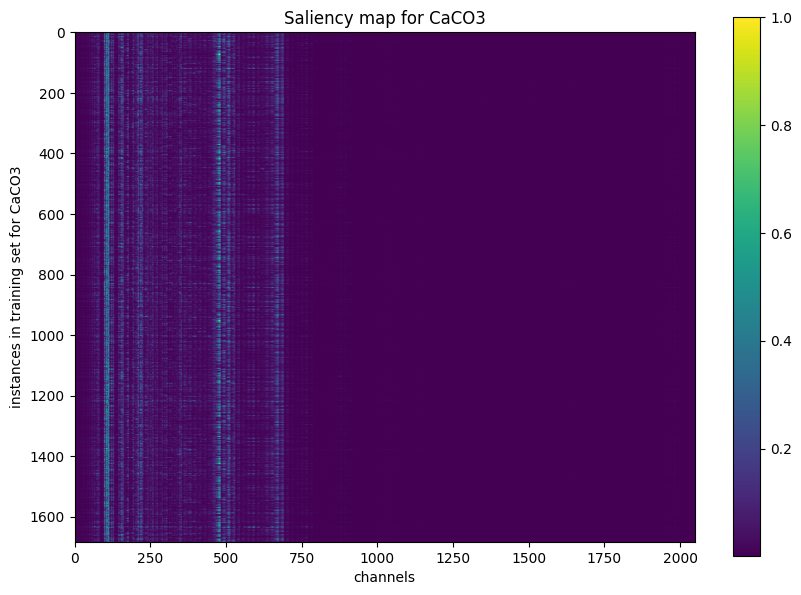

In [84]:
model.eval()
model = model.cuda()

total_saliency_map = torch.empty([0, 2048])
for batch in dataloader["train"]:
    samples = batch["spe"].to(device, non_blocking=True, dtype=torch.float)
    samples.requires_grad = True
    targets = batch["target"].to(device, non_blocking=True, dtype=torch.float)

    preds = model(samples)
    loss = criterion(preds, targets)
    loss.backward()

    saliency_map = samples.grad.data.abs()
    saliency_map /= saliency_map.max(dim=-1)[0].unsqueeze(dim=-1)
    total_saliency_map = torch.concat([total_saliency_map, saliency_map.cpu()], dim=0)

fig, ax = plt.subplots(figsize=(10, 7))
ax.set_xlabel("channels")
ax.set_ylabel(f"instances in training set for {target_task}")
ax.set_title(f"Saliency map for {target_task}")
cax = ax.imshow(total_saliency_map.cpu().numpy())
cbar = fig.colorbar(cax, ax=ax, orientation='vertical')
plt.show()